## Environment Setup: Importing Necessary Libraries

In [1]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install python-terrier
!pip install keybert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.0/318.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.p

In [3]:
import glob
import os
import pickle
import re
from collections import OrderedDict

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import pyterrier as pt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from pyterrier.measures import *
from keybert import KeyBERT
from transformers import AutoTokenizer, AutoModel

nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

nltk.download('punkt')

if not pt.started():
  pt.init(boot_packages=["com.github.terrierteam:terrier-prf:-SNAPSHOT"])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


terrier-assemblies 5.8 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done
terrier-prf -SNAPSHOT jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.10.0 has loaded Terrier 5.8 (built by craigm on 2023-11-01 18:05) and terrier-helper 0.0.8



# Data Acquisition: Loading and Understanding the Dataset

## Dataset

In [4]:
# Open the pickle file
pickle_file_path = '/content/drive/MyDrive/Information Retrieval and Recommender Systems/PROJECT/extracted_information.pkl'


# Load the data from the pickle file into a list of dictionaries
with open(pickle_file_path, 'rb') as file:
    extracted_data = []
    while True:
        try:
            document = pickle.load(file)
            extracted_data.extend(document)
        except EOFError:
            break

In [5]:
df = pd.DataFrame(extracted_data)
df = df.rename(columns={"nct_id":"docno"})
display(df.head())
print(f'Total number of documents: {len(df)}')

,docno,brief_title,official_title,brief_summary,detailed_description,study_type,study_design_info_primary_purpose,condition,intervention_intervention_type,intervention_intervention_name,...,trials_keyword,condition_browse_mesh_term,intervention_browse_mesh_term,eligibility_criteria,eligibility_inclusion_criteria,eligibility_exclusion_criteria,eligibility_gender,eligibility_minimum_age,eligibility_maximum_age,eligibility_healthy_volunteers
0,NCT00976963,Single Dose Monurol for Treatment of Acute Cys...,Single Dose Monurol for Treatment of Acute Cys...,Urinary tract infecton (UTI) is a very common ...,Procedures subjects will undergo once they hav...,Interventional,Treatment,Urinary Tract Infection,Drug,Fosfomycin,...,UTI,Urinary Tract Infections,Fosfomycin,Inclusion Criteria:\r\n\r\n - Non pr...,:\r\n\r\n - Non pregnant women in go...,":\r\n\r\n - Pregnant, lactating, or ...",Female,18 Years,45 Years,Accepts Healthy Volunteers
1,NCT00976573,"Carboplatin, Paclitaxel, and Bevacizumab With ...","A Randomized Phase II Trial of Carboplatin, Pa...",This randomized phase II trial is studying how...,OBJECTIVES:\r\n\r\n Primary\r\n\r\n ...,Interventional,Treatment,Melanoma (Skin),Biological,bevacizumab,...,"Stage IV Skin Melanoma, recurrent melanoma",Melanoma,"Paclitaxel, Bevacizumab, Carboplatin, Everolimus",Inclusion Criteria:\r\n\r\n - Histol...,:\r\n\r\n - Histologic proof of stag...,- Prior treatment with agents disrupting vasc...,All,18 Years,N/A,No
2,NCT00971139,Implementing Online Patient-Provider Communica...,Implementing Online Patient-Provider Communica...,"This interdisciplinary, international collabor...",A rapidly growing research literature document...,Interventional,Supportive Care,Cancer,Behavioral,Access to an OPPC service,...,"Online patient-provider communication, Organiz...",,,Inclusion Criteria:\r\n\r\n - 18 yea...,:\r\n\r\n - 18 years of age.\r\n\r\n...,:\r\n\r\n - Excluded are patients wh...,All,18 Years,N/A,No
3,NCT00977769,Carbetocin Versus Oxytocin and Hemodynamic Eff...,"Hemodynamic Effects of Carbetocin 100 µg, Oxyt...",A randomized double-blind trial of oxytocin 5 ...,Healthy pregnant women sheduled for elective c...,Interventional,Treatment,"Effects of; Anesthesia, in Pregnancy",Drug,carbetocin 100 µg,...,"cesarean delivery, blood pressure, cardiac output",,"Oxytocin, Carbetocin",Inclusion Criteria:\r\n\r\n - Health...,:\r\n\r\n - Healthy pregnant women f...,:\r\n\r\n - Bleeding disorders\r\n\r...,Female,18 Years,50 Years,No
4,NCT00976924,Clinical Test of Blood Glucose Test Strips,Clinical Test of Blood Glucose Test Strips,Blood glucose test strips are tested with the ...,,Interventional,Diagnostic,Diabetes,Device,blood glucose monitor,...,blood glucose,,,Inclusion Criteria:\r\n\r\n - The pa...,:\r\n\r\n - The patients with blood ...,:\r\n\r\n - The patients with blood ...,All,22 Years,78 Years,Accepts Healthy Volunteers


Total number of documents: 375580


## Queries

In [6]:
# Queries
!pip install --upgrade ir_datasets
dataset = pt.get_dataset('irds:clinicaltrials/2021/trec-ct-2022')
queries = dataset.get_topics(variant='text')
display(queries)

[INFO] [starting] https://www.trec-cds.org/topics2022.xml
[INFO] [finished] https://www.trec-cds.org/topics2022.xml: [00:00] [32.4kB] [1.49MB/s]


,qid,query
0,1,a 19 year old male came to clinic with some se...
1,2,a 32 year old woman comes to the hospital with...
2,3,a 51 year old man comes to the office complain...
3,4,a 66 year old woman comes to the office due to...
4,5,a 23 year old man comes to the emergency depar...
5,6,a 61 year old man comes to the clinic due to n...
6,7,a 3 year old girl is brought to the clinic by ...
7,8,a 7 month old boy is brought to emergency by h...
8,9,a 67 year old woman comes to the clinic due to...
9,10,a 19 year old girl comes to the clinic due to ...


## Qrels

In [7]:
#Qrels
#!gdown --id 1RYHxr2sM9Hd2C2iRI_NXzO4RY71Adu-p

path_to_qrels = '/content/drive/MyDrive/Information Retrieval and Recommender Systems/PROJECT/clc_qrels2022.txt'
qrels = pd.read_csv(path_to_qrels, names=['qid','Q0','docno','label'],sep=" ",header=None)
qrels = qrels.drop(columns=['Q0'])
qrels["qid"] = qrels["qid"].astype(str)
qrels["docno"] = qrels["docno"].astype(str)
display(qrels.head(2))

,qid,docno,label
0,1,NCT00000409,0
1,1,NCT00001148,0


# Exploratory Analysis: Gaining Insights from the Data


In [8]:
# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows

print("Dataframe Information:\n\n")
display(df.info())
print("\n\nDataframe Description:\n\n")
display(df.describe())
print("\n\nUnique vaues per column:\n\n")
display(df.nunique())

Dataframe Information:


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375580 entries, 0 to 375579
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   docno                              375580 non-null  object
 1   brief_title                        375580 non-null  object
 2   official_title                     375580 non-null  object
 3   brief_summary                      375580 non-null  object
 4   detailed_description               375580 non-null  object
 5   study_type                         375580 non-null  object
 6   study_design_info_primary_purpose  375580 non-null  object
 7   condition                          375580 non-null  object
 8   intervention_intervention_type     375580 non-null  object
 9   intervention_intervention_name     375580 non-null  object
 10  location                           375580 non-null  object
 11  trials_keyword             

None



Dataframe Description:




,docno,brief_title,official_title,brief_summary,detailed_description,study_type,study_design_info_primary_purpose,condition,intervention_intervention_type,intervention_intervention_name,location,trials_keyword,condition_browse_mesh_term,intervention_browse_mesh_term,eligibility_criteria,eligibility_inclusion_criteria,eligibility_exclusion_criteria,eligibility_gender,eligibility_minimum_age,eligibility_maximum_age,eligibility_healthy_volunteers
count,375580,375580,375580,375580,375580,375580,375580,375580,375580,375580,375580,375580,375580,375580,375580,375580,375580,375580,375580,375580,375580
unique,375580,373511,362581,372730,247916,5,11,58727,12,202466,112703,225801,2976,28658,370583,366769,349964,4,248,455,3
top,NCT00976963,[Trial of device that is not approved or clear...,,,,Interventional,Treatment,Healthy,Drug,,,,,,,,,All,18 Years,N/A,No
freq,1,841,10085,842,126028,292650,191257,7383,141625,39254,51453,132421,65953,245037,932,1204,7560,320948,231211,178998,272139




Unique vaues per column:




docno                                375580
brief_title                          373511
official_title                       362581
brief_summary                        372730
detailed_description                 247916
study_type                                5
study_design_info_primary_purpose        11
condition                             58727
intervention_intervention_type           12
intervention_intervention_name       202466
location                             112703
trials_keyword                       225801
condition_browse_mesh_term             2976
intervention_browse_mesh_term         28658
eligibility_criteria                 370583
eligibility_inclusion_criteria       366769
eligibility_exclusion_criteria       349964
eligibility_gender                        4
eligibility_minimum_age                 248
eligibility_maximum_age                 455
eligibility_healthy_volunteers            3
dtype: int64

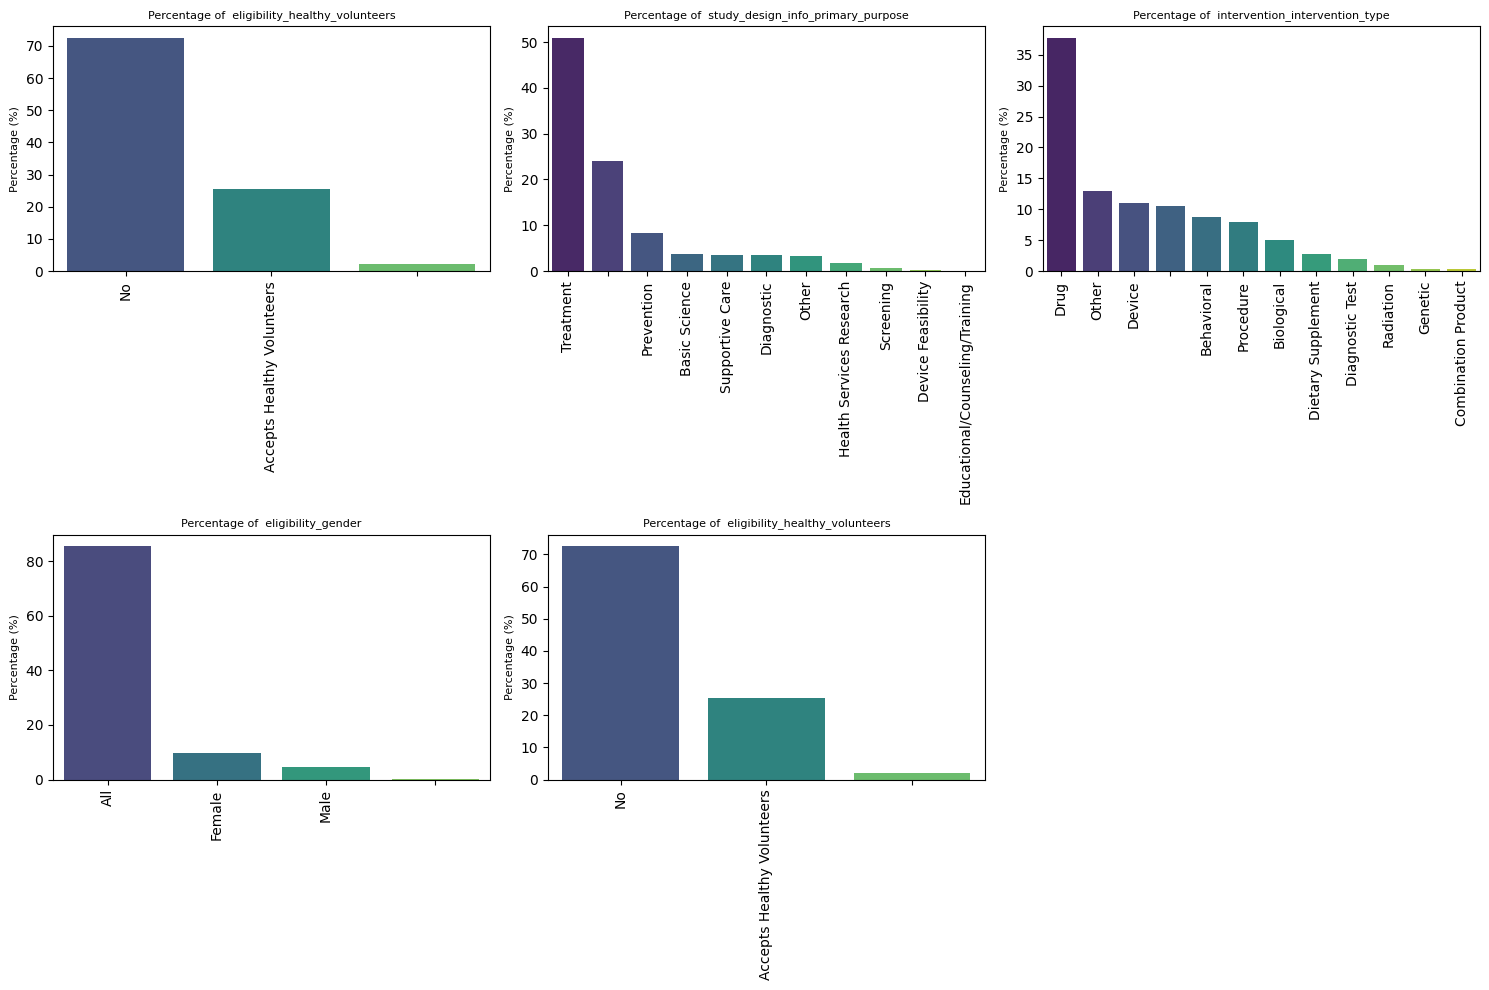

In [9]:
columns = ['eligibility_healthy_volunteers',
           'study_design_info_primary_purpose',
           'intervention_intervention_type',
           'eligibility_gender',
           'eligibility_healthy_volunteers']

# Calculate the percentages
percentages = [round(df[col].value_counts() / sum(df[col].value_counts()) * 100, 2) for col in columns]

# 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15,10))

axs = axs.flatten()

for i in range(5):
    sns.barplot(x=percentages[i].index, y=percentages[i].values, palette="viridis", ax=axs[i])

    # labels and title
    axs[i].set_ylabel('Percentage (%)', fontsize=8)
    axs[i].set_title('Percentage of '+' '+columns[i], fontsize=8)

    axs[i].tick_params(axis='x', rotation=90)

axs[-1].axis('off')

plt.subplots_adjust(wspace=0.4, hspace=0.6)

plt.tight_layout()

plt.show()

In [10]:
columns_to_drop = ["study_type", "study_design_info_primary_purpose","intervention_intervention_type",
                   "location", "eligibility_gender", "eligibility_minimum_age", "eligibility_maximum_age","eligibility_criteria",
                   "eligibility_healthy_volunteers"]

try: df = df.drop(columns_to_drop, axis=1)
except: None

display(df.head())
print(f"rows = {df.shape[0]}\ncolumns = {df.shape[1]}")

,docno,brief_title,official_title,brief_summary,detailed_description,condition,intervention_intervention_name,trials_keyword,condition_browse_mesh_term,intervention_browse_mesh_term,eligibility_inclusion_criteria,eligibility_exclusion_criteria
0,NCT00976963,Single Dose Monurol for Treatment of Acute Cys...,Single Dose Monurol for Treatment of Acute Cys...,Urinary tract infecton (UTI) is a very common ...,Procedures subjects will undergo once they hav...,Urinary Tract Infection,Fosfomycin,UTI,Urinary Tract Infections,Fosfomycin,:\r\n\r\n - Non pregnant women in go...,":\r\n\r\n - Pregnant, lactating, or ..."
1,NCT00976573,"Carboplatin, Paclitaxel, and Bevacizumab With ...","A Randomized Phase II Trial of Carboplatin, Pa...",This randomized phase II trial is studying how...,OBJECTIVES:\r\n\r\n Primary\r\n\r\n ...,Melanoma (Skin),bevacizumab,"Stage IV Skin Melanoma, recurrent melanoma",Melanoma,"Paclitaxel, Bevacizumab, Carboplatin, Everolimus",:\r\n\r\n - Histologic proof of stag...,- Prior treatment with agents disrupting vasc...
2,NCT00971139,Implementing Online Patient-Provider Communica...,Implementing Online Patient-Provider Communica...,"This interdisciplinary, international collabor...",A rapidly growing research literature document...,Cancer,Access to an OPPC service,"Online patient-provider communication, Organiz...",,,:\r\n\r\n - 18 years of age.\r\n\r\n...,:\r\n\r\n - Excluded are patients wh...
3,NCT00977769,Carbetocin Versus Oxytocin and Hemodynamic Eff...,"Hemodynamic Effects of Carbetocin 100 µg, Oxyt...",A randomized double-blind trial of oxytocin 5 ...,Healthy pregnant women sheduled for elective c...,"Effects of; Anesthesia, in Pregnancy",carbetocin 100 µg,"cesarean delivery, blood pressure, cardiac output",,"Oxytocin, Carbetocin",:\r\n\r\n - Healthy pregnant women f...,:\r\n\r\n - Bleeding disorders\r\n\r...
4,NCT00976924,Clinical Test of Blood Glucose Test Strips,Clinical Test of Blood Glucose Test Strips,Blood glucose test strips are tested with the ...,,Diabetes,blood glucose monitor,blood glucose,,,:\r\n\r\n - The patients with blood ...,:\r\n\r\n - The patients with blood ...


rows = 375580
columns = 12


# Data Normalization: Preparing for Information Retrieval

In [11]:
# Function for query processing
def apply_processing(column):

  # remove punctuation
  punctuation=r'[\\.,/#;:{}=\[\]\(\)\{\}^_*`~+\-]'
  column = column.apply(lambda x: re.sub(punctuation, ' ', x))
#
  ### remove white spaces
  column = column.apply(lambda x: re.sub(r'\s\s+', ' ', x))
#
  ### remove stop words and lowering
  column =column.apply(lambda x: " ".join([w.lower() for w in x.split() if w.lower() not in stop_words]))


  return column

## Dataset Preprocessing

In [12]:
for c in df.columns[1:]:
  df[c] = apply_processing(df[c])

In [13]:
print("After Preprocessing:\n\n")
df.head()

After Preprocessing:




,docno,brief_title,official_title,brief_summary,detailed_description,condition,intervention_intervention_name,trials_keyword,condition_browse_mesh_term,intervention_browse_mesh_term,eligibility_inclusion_criteria,eligibility_exclusion_criteria
0,NCT00976963,single dose monurol treatment acute cystitis,single dose monurol treatment acute cystitis,urinary tract infecton uti common problem youn...,procedures subjects undergo read signed consen...,urinary tract infection,fosfomycin,uti,urinary tract infections,fosfomycin,non pregnant women good health symptoms acute ...,pregnant lactating regularly contracepting his...
1,NCT00976573,carboplatin paclitaxel bevacizumab without eve...,randomized phase ii trial carboplatin paclitax...,randomized phase ii trial studying well carbop...,objectives primary assess whether sufficient p...,melanoma skin,bevacizumab,stage iv skin melanoma recurrent melanoma,melanoma,paclitaxel bevacizumab carboplatin everolimus,histologic proof stage iv malignant melanoma a...,prior treatment agents disrupting vascular end...
2,NCT00971139,implementing online patient provider communica...,implementing online patient provider communica...,interdisciplinary international collaboration ...,rapidly growing research literature documents ...,cancer,access oppc service,online patient provider communication organiza...,,,18 years age able read speak norwegian interne...,excluded patients brain metastasis patients ce...
3,NCT00977769,carbetocin versus oxytocin hemodynamic effects,hemodynamic effects carbetocin 100 µg oxytocin...,randomized double blind trial oxytocin 5 u car...,healthy pregnant women sheduled elective cesar...,effects anesthesia pregnancy,carbetocin 100 µg,cesarean delivery blood pressure cardiac output,,oxytocin carbetocin,healthy pregnant women planned cesarean section,bleeding disorders placenta disorders
4,NCT00976924,clinical test blood glucose test strips,clinical test blood glucose test strips,blood glucose test strips tested test meters t...,,diabetes,blood glucose monitor,blood glucose,,,patients blood glucose within range iso15197,patients blood glucose range iso15197


## Queries Preprocessing

In [14]:
queries['query'] = apply_processing(queries["query"])

In [15]:
print("After Preprocessing:\n\n")
queries.head()

After Preprocessing:




,qid,query
0,1,19 year old male came clinic sexual concern re...
1,2,32 year old woman comes hospital vaginal spott...
2,3,51 year old man comes office complaining fatig...
3,4,66 year old woman comes office due joint pain ...
4,5,23 year old man comes emergency department fol...


# Building the Index: Facilitating Efficient Search

## Baseline Experiment

In [16]:
bsl_indexer = pt.DFIndexer("./baseline_index", overwrite=True, stemmer=None, stopwords=True)


df_all = pd.DataFrame({
    "docno": df["docno"],
    "text": df["brief_title"] + " " + df["official_title"] + " " +
            df["brief_summary"] + " " + df["detailed_description"] + " " +
            df["condition"] + " " + df["intervention_intervention_name"] + " " +
            df["trials_keyword"] + " " + df["condition_browse_mesh_term"] + " " +
            df["intervention_browse_mesh_term"]  + " " + df["eligibility_inclusion_criteria"] + " " + df["eligibility_exclusion_criteria"]
})

bsl_index_ref = bsl_indexer.index(df_all["text"], df_all['docno'])

display(bsl_index_ref.toString())

'./baseline_index/data.properties'

In [17]:
tf_idf = pt.BatchRetrieve(bsl_index_ref, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(bsl_index_ref, wmodel="BM25")
pl2 = pt.BatchRetrieve(bsl_index_ref, wmodel="PL2")

In [18]:
## Evaluation Measures
####Relevance labels of 2 are considered as relevant
metrics_eval = [
 RR(rel=2)@1000,
 P(rel=2)@1 , P(rel=2)@5 , P(rel=2)@10 , P(rel=2)@25 , P(rel=2)@30, P(rel=2)@75,
 Rprec(rel=2),
 R(rel=2)@10, R(rel=2)@25,
]

## Perform retrieval
#Evaluate
bsl_results = pt.Experiment(
    [tf_idf, bm25, pl2],
    queries,
    qrels,
    eval_metrics=metrics_eval,
    names=["TF-IDF", "BM25", "PL2"],
    baseline=0,
    perquery = False,
)

display(bsl_results)

,name,Rprec(rel=2),P(rel=2)@1,P(rel=2)@5,P(rel=2)@10,P(rel=2)@25,P(rel=2)@30,P(rel=2)@75,R(rel=2)@10,R(rel=2)@25,RR(rel=2)@1000,Rprec(rel=2) +,Rprec(rel=2) -,Rprec(rel=2) p-value,P(rel=2)@1 +,P(rel=2)@1 -,P(rel=2)@1 p-value,P(rel=2)@5 +,P(rel=2)@5 -,P(rel=2)@5 p-value,P(rel=2)@10 +,P(rel=2)@10 -,P(rel=2)@10 p-value,P(rel=2)@25 +,P(rel=2)@25 -,P(rel=2)@25 p-value,P(rel=2)@30 +,P(rel=2)@30 -,P(rel=2)@30 p-value,P(rel=2)@75 +,P(rel=2)@75 -,P(rel=2)@75 p-value,R(rel=2)@10 +,R(rel=2)@10 -,R(rel=2)@10 p-value,R(rel=2)@25 +,R(rel=2)@25 -,R(rel=2)@25 p-value,RR(rel=2)@1000 +,RR(rel=2)@1000 -,RR(rel=2)@1000 p-value
0,TF-IDF,0.168768,0.34,0.308,0.276,0.2328,0.222000,0.165333,0.053577,0.097027,0.486336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25,0.189476,0.34,0.316,0.298,0.2480,0.237333,0.176267,0.059704,0.107545,0.485483,27.0,5.0,0.001113,2.0,2.0,1.0,9.0,6.0,0.687371,11.0,3.0,0.039793,17.0,5.0,0.020588,17.0,4.0,0.009168,26.0,6.0,0.000428,11.0,3.0,0.129127,17.0,5.0,0.056823,14.0,15.0,0.977908
2,PL2,0.174564,0.34,0.312,0.276,0.2344,0.226000,0.172533,0.055624,0.100420,0.478376,20.0,11.0,0.340128,0.0,0.0,NaN,10.0,7.0,0.843810,11.0,8.0,1.000000,16.0,11.0,0.859568,15.0,14.0,0.633535,28.0,9.0,0.168910,11.0,8.0,0.543637,16.0,11.0,0.423057,12.0,12.0,0.573543


## "Bad" and "Good" Index

In [19]:
include_indexer = pt.DFIndexer("./include_index", overwrite=True, stemmer=None, stopwords=True)
exclude_indexer = pt.DFIndexer("./exclude_index", overwrite=True, stemmer=None, stopwords=True)

df_include = pd.DataFrame({
    "docno": df["docno"],
    "text": df["brief_title"] + " " + df["official_title"] + " " +
            df["brief_summary"] + " " + df["detailed_description"] + " " +
            df["condition"] + " " + df["intervention_intervention_name"] + " " +
            df["trials_keyword"] + " " + df["condition_browse_mesh_term"] + " " +
            df["intervention_browse_mesh_term"]  + " " + df["eligibility_inclusion_criteria"]
})

df_exclude = pd.DataFrame({
    "docno": df["docno"],
    "text": df["eligibility_exclusion_criteria"]
})

include_index_ref = include_indexer.index(df_include["text"], df_include['docno'])
exclude_index_ref = exclude_indexer.index(df_exclude["text"], df_exclude['docno'])

10:34:04.007 [main] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (NCT00977613) - further warnings are suppressed
10:39:11.911 [main] WARN org.terrier.structures.indexing.Indexer - Indexed 10972 empty documents


# Query Processing: Enhancing Search Accuracy

In [20]:
# Load pre-trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

kw_model = KeyBERT(model=model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/968 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.09k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/471M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

unigram.json:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [21]:
def extract_keywords(query,
                     top_n,
                     keyphrase_ngram_range,
                     diversity):
  id = query['qid']

  q = query['query'].apply(
      lambda x: " ".join(set((" ".join(kw[0] for kw in kw_model.extract_keywords(x,
                                                                 keyphrase_ngram_range=keyphrase_ngram_range,
                                                                 top_n=top_n,
                                                                 min_df=0,
                                                                 use_maxsum=True,
                                                                 use_mmr=True,
                                                                 diversity=diversity))).split())))
  return pd.DataFrame(
      {'qid':id,
       'query':q})

In [22]:
long_kw_queries = extract_keywords(query=queries, top_n=30, keyphrase_ngram_range=(5,6), diversity=0.6)
short_kw_queries = extract_keywords(query=long_kw_queries, top_n=15, keyphrase_ngram_range=(2,3), diversity=0.3)

# Model Implementation: Crafting the Retrieval System

In [23]:
inc_bm25 = pt.BatchRetrieve(include_index_ref, wmodel="BM25")
exc_bm25 = pt.BatchRetrieve(exclude_index_ref, wmodel="BM25")

In [24]:
inc_def_queries_res=inc_bm25.transform(queries)
inc_long_kw_queries_res=inc_bm25.transform(long_kw_queries)
inc_short_kw_queries_res=inc_bm25.transform(short_kw_queries)

exc_def_queries_res=exc_bm25.transform(queries)
exc_long_kw_queries_res=exc_bm25.transform(long_kw_queries)
exc_short_kw_queries_res=exc_bm25.transform(short_kw_queries)

In [36]:
inclusion_results_df = pd.DataFrame(columns={
    'qid':[],
    'docno':[],
    'score':[],
    'rank':[]
})

for i in range(51):


    a = inc_def_queries_res.loc[inc_def_queries_res['qid'] == str(i)][['docno', 'score']]
    b = inc_long_kw_queries_res.loc[inc_long_kw_queries_res['qid'] == str(i)][['docno', 'score']]
    c = inc_short_kw_queries_res.loc[inc_short_kw_queries_res['qid'] == str(i)][['docno', 'score']]

    y = exc_def_queries_res.loc[inc_def_queries_res['qid'] == str(i)][['docno', 'score']]
    x = exc_long_kw_queries_res.loc[inc_long_kw_queries_res['qid'] == str(i)][['docno', 'score']]
    z = exc_short_kw_queries_res.loc[inc_short_kw_queries_res['qid'] == str(i)][['docno', 'score']]


    # Lists to store data for DataFrame
    qid_list = []
    docno_list = []
    score_list = []

    ith_inclusion_query_results = [a, b, c]

    ith_exclusion_query_results = [x, y, z]

    partial_inclusion_results = {}

    partial_exclusion_results = {}

    for _ in ith_inclusion_query_results:
        for r in _.values:
            key = (str(i), r[0])
            value = r[1] / 3

            if key not in partial_inclusion_results.keys():
                partial_inclusion_results[key] = value
            else:
                partial_inclusion_results[key] += value

    for _ in ith_exclusion_query_results:
        for r in _.values:
            key = (str(i), r[0])
            value = r[1] / 3

            if key not in partial_exclusion_results.keys():
                partial_exclusion_results[key] = value
            else:
                partial_exclusion_results[key] += value


    # removal part
    partial_exclusion_results = dict(sorted(partial_exclusion_results.items(), key=lambda x:x[1], reverse=True)) # order bad result in order of relevance
    partial_exclusion_keys = list(partial_exclusion_results.keys()) # extract keys by relevance
    top10=int(len(partial_exclusion_keys) * 0.1) # remove 5% of bad docs

    for key in partial_exclusion_keys[:top35]:
      partial_inclusion_results.pop(key, None)

    partial_inclusion_results = dict(sorted(partial_inclusion_results.items(), key=lambda x:x[1], reverse=True))

    # Update lists for DataFrame
    for key, value in partial_inclusion_results.items():
        qid_list.append(key[0])
        docno_list.append(key[1])
        score_list.append(value)

    rank_list = [i for i in range(len(qid_list))]
    # Create DataFrame
    partial_inclusion_df = pd.DataFrame({
        'qid': qid_list,
        'docno': docno_list,
        'score': score_list,
        'rank' : rank_list
    })

    inclusion_results_df = pd.concat([inclusion_results_df, partial_inclusion_df], ignore_index=True)

# Performance Evaluation: Assessing the Search Results

In [38]:
metrics_eval = [
 RR(rel=2)@1000,
 P(rel=2)@1 , P(rel=2)@5 , P(rel=2)@10 , P(rel=2)@25 , P(rel=2)@30, P(rel=2)@75,
 Rprec(rel=2),
 R(rel=2)@10, R(rel=2)@25,
]

In [39]:
pt.Experiment(
    [inclusion_results_df, tf_idf, bm25, pl2],
    topics=queries,
    qrels=qrels,
    eval_metrics=metrics_eval,
    names=['Our Model', "TF-IDF", "BM25", "PL2"],
)

,name,RR(rel=2)@1000,P(rel=2)@1,P(rel=2)@5,P(rel=2)@10,P(rel=2)@25,P(rel=2)@30,P(rel=2)@75,Rprec(rel=2),R(rel=2)@10,R(rel=2)@25
0,Our Model,0.481392,0.32,0.340,0.300,0.2504,0.234667,0.171200,0.181377,0.059788,0.107735
1,TF-IDF,0.486336,0.34,0.308,0.276,0.2328,0.222000,0.165333,0.168768,0.053577,0.097027
2,BM25,0.485483,0.34,0.316,0.298,0.2480,0.237333,0.176267,0.189476,0.059704,0.107545
3,PL2,0.478376,0.34,0.312,0.276,0.2344,0.226000,0.172533,0.174564,0.055624,0.100420
